# Lecture 5 - More Power and Early Stopping in A/B Testing

## Today's Learning Objectives

1. Comment on nuances of randomized experiments that arise specifically for website optimization problems.
2. Determine an adequate sample size (i.e., experiment duration) for such problems.
3. Apply clever plotting arrangements to communicate power analyses.
4. Relate the danger of "early stopping" to experiments in A/B testing.
5. Analyze the advantages and disadvantages of aggressive and principled peekings in A/B testing.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8)
library(tidyverse)
library(pwr)
library(broom)
library(scales)
library(cowplot)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor





Attaching package: ‘cowplot’




The following object is masked from ‘package:lubridate’:

    stamp




## 1. Sample Size Computations in Plots

We already introduced the `R` function `pwr.t.test()` from library `pwr` to compute sample sizes in an A/B testing framework where the response is continuous. Moreover, we generated a table with different scenarios of **power $1 - \beta$**, **significance level $\alpha$**, and **effect difference $\delta$** (i.e., the effect difference between the control and experimental treatments in terms of the outcome of interest).

We also introduced a handy Power Analysis plotting arrangement in {doc}`lecture4_more_blocking_and_power`.

**Let us explore other plotting alternatives!**

### 1.1. Revisiting the Example

We want to do an A/B testing to see if a tweak (**version B**) of our existing site (**version A**) promotes site visitors to stay longer. 

```{attention}
The boss will not sign off on this without some certainty around how many visitors will be randomized to either version A or B.
```

**We know that CURRENTLY, around 95% of the visitors stay between 30 seconds and 2 minutes.** Moreover, we would permanently switch to the tweaked site if we were convinced it improved visit length by 3% (or more!).

```{admonition} Main Statistical Inquiry
Given the problem's setup, how large should we set up our sample size so we can detect this difference (if there is any)?
```

### 1.2. Using Function `pwr.t.test()`

We will not go into the specific details on the use of the function `pwr.t.test()` and the computations of $\mu_A = 1.25$ and $\sigma = 0.383$ min. Nonetheless, we need to set up the following values for computing different sample sizes:

- A single value for $\alpha = 0.05$ (i.e., the default **significance level**).
- $1 - \beta$ (**power**): $0.70$, $0.80$, and $0.90$. The larger the **power**, the less prone we will be to commit type II error.
- Increases in the response of interest with $\delta = 0.0375, 0.0625, 0.0875, 0.1125, 0.1375, 0.1625$ in treatment B with respect to treatment A (i.e., increases of 3, 5, 7, 9, 11, and 13%).

As previously done in {doc}`lecture4_more_blocking_and_power`, we need to prepare a grid with all the possible combinations for `alpha`, `power`, and `delta`.

In [2]:
# Let us obtain all possible setting combinations
alpha <- 0.05
power <- c(0.7, 0.8, 0.9)
delta <- c(0.0375, 0.0625, 0.0875, 0.1125, 0.1375, 0.1625)
experimental_grid <- expand.grid(alpha, power, delta)
colnames(experimental_grid) <- c("alpha", "power", "delta")
# Adding a column for the overall sample size n
experimental_grid$overall_n <- NA
experimental_grid

alpha,power,delta,overall_n
<dbl>,<dbl>,<dbl>,<lgl>
0.05,0.7,0.0375,NA
0.05,0.8,0.0375,NA
0.05,0.9,0.0375,NA
0.05,0.7,0.0625,NA
⋮,⋮,⋮,⋮
0.05,0.9,0.1375,NA
0.05,0.7,0.1625,NA
0.05,0.8,0.1625,NA
0.05,0.9,0.1625,NA


Then, we use the function `pwr.t.test()` with all the possible combinations from `experimental_grid`. We also need to set up the value for `sigma`. Recall the elements of `pwr.t.test()`:

- `d`: Desired effect size ($\delta$ divided by $\sigma$).
- `sig.level`: Chosen $\alpha$.
- `power`: Chosen power $1 - \beta$.
- `type`: Type of test (in the A/B testing context we have a `two.sample` test).
- `alternative`: Our hypothesis test is one-sided, thus `greater`.

In [3]:
sigma <- 0.383
for (i in 1:nrow(experimental_grid)) {
  # Using pwr.t.test() function
  sample_size <- tidy(pwr.t.test(
    d = experimental_grid[i, "delta"] / sigma,
    sig.level = experimental_grid[i, "alpha"],
    power = experimental_grid[i, "power"],
    type = "two.sample",
    alternative = "greater"
  ))

  # Recording overall sample size
  experimental_grid[i, "overall_n"] <- 2 * ceiling(sample_size$n)
}

Once we have run our sample size computations, we have the table of results below.

In [4]:
options(repr.matrix.max.rows = 18)
experimental_grid <- experimental_grid %>%
  mutate(power = as.factor(power))
experimental_grid

alpha,power,delta,overall_n
<dbl>,<fct>,<dbl>,<dbl>
0.05,0.7,0.0375,1966
0.05,0.8,0.0375,2582
0.05,0.9,0.0375,3576
0.05,0.7,0.0625,710
0.05,0.8,0.0625,932
0.05,0.9,0.0625,1288
0.05,0.7,0.0875,362
0.05,0.8,0.0875,476
0.05,0.9,0.0875,658


### 1.3. Plotting Results

The data frame `experimental_grid` can be plotted as follows:

In [5]:
options(repr.plot.height = 8, repr.plot.width = 14)

t_sample_size_plot <- ggplot(experimental_grid, aes(x = delta, y = overall_n, colour = power)) +
  geom_point(size = 4) +
  geom_line(linewidth = 1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.position = "bottom",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Response Increase with Experimental Treatment B (%)", y = "Overall Sample Size n") +
  coord_cartesian(xlim = c(0.0375, 0.1625), ylim = c(0, 4000)) +
  scale_y_continuous(breaks = seq(0, 4000, 500)) +
  scale_x_continuous(breaks = delta, labels = c(3, 5, 7, 9, 11, 13)) +
  labs(colour = "Power") +
  ggtitle(expression("A/B Testing Overall Sample Size Computations with"~alpha~"= 0.05")) +
  scale_color_brewer(palette = "Dark2")

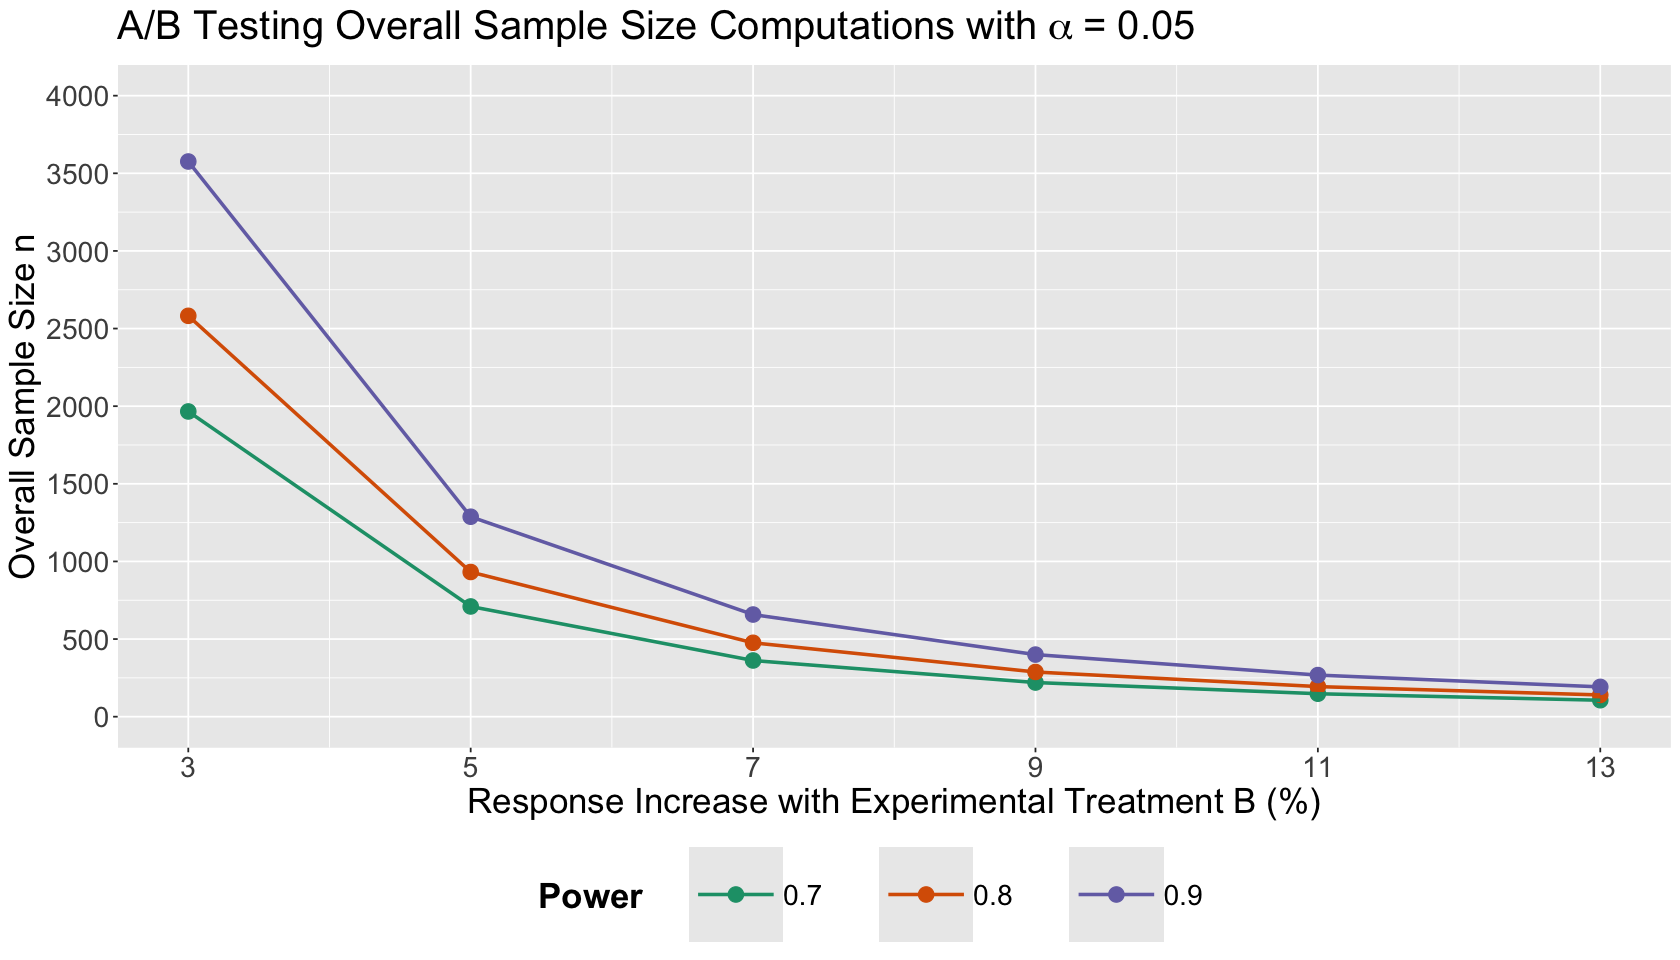

In [6]:
t_sample_size_plot

```{exercise}
:label: lecture5-q1

Use the above Power Analysis plot to answer this question.

If we cannot anticipate a large percentage response increase with our experimental version B, compared to control treatment A, what can we state about the overall sample size?

**Select the correct option:**

**A.** If we cannot ensure a large percentage response increase with our experimental version B in mean duration visits, compared to control treatment A, our A/B testing will require **more experimental units**.

**B.** If we cannot ensure a large percentage response increase with our experimental version B in mean duration visits, compared to control treatment A, our A/B testing will require **less experimental units**.
```

### 1.4. Alternative Plotting

Suppose your boss tells you there is **available budget** for an A/B testing for an overall simple size up to $n = 1000$. You can use `pwr.t.test()` to compute the corresponding levels of power with the following settings:

- **Overall sample sizes** from $100$ to $1000$ increasing by $100$.
- A single value for $\alpha = 0.05$ (i.e., the default **significance level**).
- Increases in the response of interest with $\delta = 0.0375, 0.0625, 0.0875, 0.1125, 0.1375, 0.1625$ in treatment B with respect to treatment A (i.e., increases of 3, 5, 7, 9, 11, and 13%).

In [7]:
# Let us obtain all possible setting combinations
sample_size_seq <- seq(100, 1000, by = 100)
experimental_grid_alt <- expand.grid(alpha, sample_size_seq, delta)
colnames(experimental_grid_alt) <- c("alpha", "sample_size", "delta")
# Adding a column for power
experimental_grid_alt$power <- NA
experimental_grid_alt

alpha,sample_size,delta,power
<dbl>,<dbl>,<dbl>,<lgl>
0.05,100,0.0375,NA
0.05,200,0.0375,NA
0.05,300,0.0375,NA
0.05,400,0.0375,NA
0.05,500,0.0375,NA
0.05,600,0.0375,NA
0.05,700,0.0375,NA
0.05,800,0.0375,NA
0.05,900,0.0375,NA


Then, we use the function `pwr.t.test()` with all the possible combinations from `experimental_grid_alt`. We use the same value for `sigma`. The elements of `pwr.t.test()` will be:

- `d`: Desired effect size ($\delta$ divided by $\sigma = 0.383$).
- `sig.level`: Chosen $\alpha$.
- `n`: Number of experimental units **PER TREATMENT**.
- `type`: Type of test (in the A/B testing context we have a `two.sample` test).
- `alternative`: Our hypothesis test is one-sided, thus `greater`.

In [8]:
for (i in 1:nrow(experimental_grid_alt)) {
  # Using pwr.t.test() function
  sample_size <- tidy(pwr.t.test(
    d = experimental_grid_alt[i, "delta"] / sigma,
    sig.level = experimental_grid_alt[i, "alpha"],
    n = experimental_grid_alt[i, "sample_size"] / 2, # We divide over 2 given the function's syntax (subsample size by treatment)
    type = "two.sample",
    alternative = "greater"
  ))

  # Recording power
  experimental_grid_alt[i, "power"] <- sample_size$power
}

The results are shown below:

In [9]:
experimental_grid_alt

alpha,sample_size,delta,power
<dbl>,<dbl>,<dbl>,<dbl>
0.05,100,0.0375,0.1232954
0.05,200,0.0375,0.1698191
0.05,300,0.0375,0.2121911
0.05,400,0.0375,0.2522567
0.05,500,0.0375,0.2905908
0.05,600,0.0375,0.3274205
0.05,700,0.0375,0.3628448
0.05,800,0.0375,0.3969099
0.05,900,0.0375,0.4296397


In [10]:
t_power_plot <- ggplot(experimental_grid_alt, aes(x = sample_size, y = power, colour = as.factor(delta))) +
  geom_point(size = 4) +
  geom_line(linewidth = 1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Overall Sample Size n", y = "Power") +
  coord_cartesian(xlim = c(100, 1000), ylim = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, 0.1)) +
  scale_x_continuous(breaks = sample_size_seq) +
  labs(colour = "Response Increase\nwith\nExperimental\nTreatment B (%)") +
  ggtitle(expression("A/B Testing Power Computation with"~alpha~"= 0.05")) +
  scale_color_brewer(palette = "Dark2") +
  scale_colour_discrete(labels = c("3%", "5%", "7%", "9%", "11%", "13%"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


The data frame `experimental_grid_alt` can be plotted as follows:

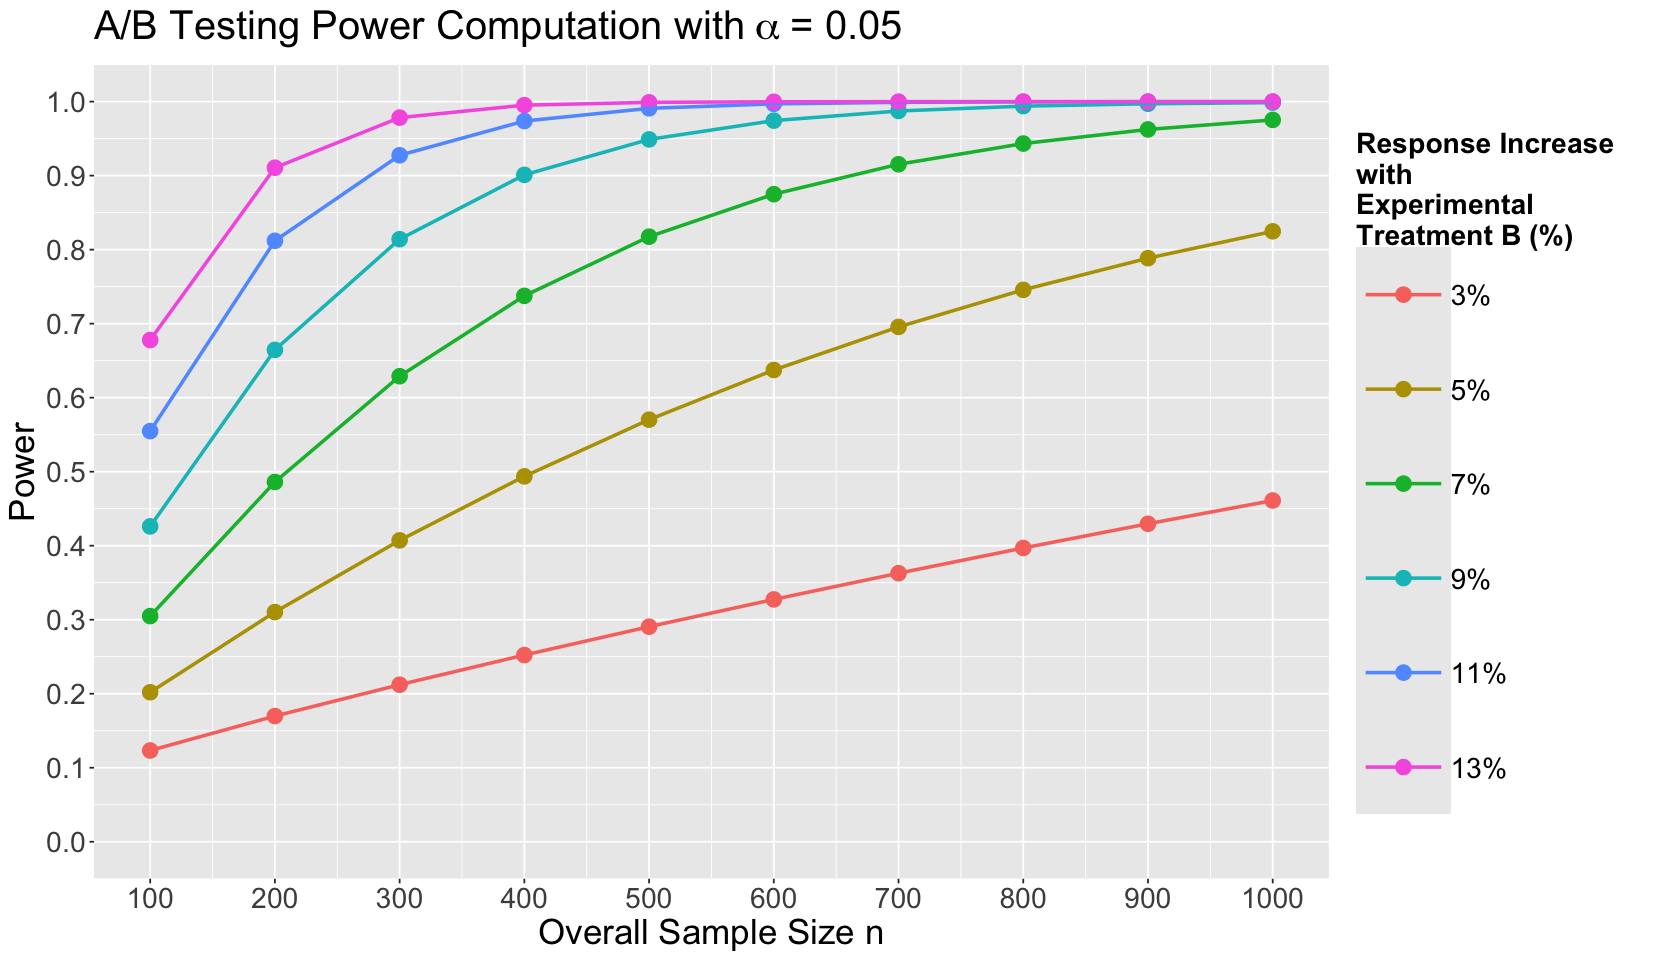

In [11]:
t_power_plot

```{exercise}
:label: lecture5-q2

Use the above Power Analysis plot to answer this question.

**Answer TRUE or FALSE:**

If we want to use a **small overall sample size $n$**, we will not struggle to find a decent power level with a response increase of 3% using our experimental treatment.

**A.** TRUE

**B.** FALSE
```

```{exercise}
:label: lecture5-q3

Use the above Power Analysis plot to answer this question.

**Answer TRUE or FALSE:**

**Beginning a response increase of 7% and beyond**, our power levels get **boosted** as we increase our overall sample sizes. This is more evident starting $n = 400$.

**A.** TRUE

**B.** FALSE
```

## 2. Sample Size Computations with Click-through Rates

So far, our A/B testing sample size computations have been focused on continuous responses. Nonetheless, recall we discussed that A/B testings could involve more than one outcome class. Thus, let us explore sample size computations with a different outcome of interest: **click-through rates (CTRs).**

Many A/B testing problems would involve a response which is **binary**. This response is measured as a CTR. Let us review this metric:

$$\text{CTR}_j = \frac{\text{Total number of clicks on the button of interest in the $j$th treatment page}}{\text{Total number of impressions on the $j$th treatment page}}.$$

This response in the experiment is a proportion. Therefore:

- $\text{CTR}_A \in [0,1]$ is the CTR of the control treatment A. 
- $\text{CTR}_B \in [0,1]$ is the CTR of the experimental treatment B.

```{attention}
In the context of a CTR, the sample size is equivalent to the **OVERALL** number of impressions in the A/B testing.
```

Since we are using a CTR as an outcome of interest, the function `pwr.t.test()` will not be helpful anymore. Hence, let us explore an alternative method. 

Let us start with a simple CTR example for sample size computation. We want to assess whether a tweak to our site would increase the CTR from $5/1000 = 0.005$ (i.e., **5 clicks per 1000 impressions in treatment A**) to $7/1000 = 0.007$ (i.e., **7 clicks per 1000 impressions in treatment B**).

In [12]:
control_A_CTR <- 5/1000
tweak_B_CTR <- 7/1000

Unlike a continuous response, **we do not need to compute $\sigma$ nor a mean for treatment A.** However, we need to compute the **effect size** $h$ for two proportions (i.e., two CTRs in an A/B testing). We will use the function `ES.h()` for this purpose. Its first argument will be the CTR for the experimental treatment B and and the second one for the control treatment A. 

In [13]:
CTR_effect_size <- ES.h(tweak_B_CTR, control_A_CTR)
round(CTR_effect_size, 3)

[1] 0.026

### 2.1. An Interlude on the Arcsine Transformation for the Effect Size

We are computing the effect size $h$ as an **arcsine transformation**:

$$\text{Effect Size } h = \left[ 2 \times \arcsin{\left(\sqrt{\text{CTR}_B} \right)} \big] - \big[ 2 \times \arcsin{\left(\sqrt{\text{CTR}_A}\right)} \right].$$

```{admonition} What is this transformation graphically doing?
:class: important
**In the below plot**, note that the $x$-axis shows three equally-spaced $\delta_{\text{CTR}}$ segments (denoted by vertical red dashed lines).

The arcsine transformation will allocate:

- a smaller **transformed effect size on the $y$-axis** between two CTRs  (denoted by horizontal purple dashed lines) as we get close to the middle of the $x$-axis (i.e., $0.5$), 
- and larger **transformed effect sizes on the $y$-axis** as we get closer to the $x$-axis extremes (either $0$ or $1$).

Moreover, note that the **transformed effect size on the $y$-axis** between 

$$\delta_{\text{CTR}} = \text{CTR}_B - \text{CTR}_A = 0.1 - 0.05 = 0.05$$ 

is equal to the one from 

$$\delta_{\text{CTR}} = \text{CTR}_B - \text{CTR}_A = 0.95 - 0.9 = 0.05.$$
```

In [14]:
effect_size_plot <- ggplot() +
  geom_function(colour = "blue", fun = ES.h, args = list(p2 = 0)) +
  xlab("CTR") +
  ylab("Transformation") +
  geom_segment(aes(x = 0.05, y = 0, xend = 0.05, yend = ES.h(0.05, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0.1, y = 0, xend = 0.1, yend = ES.h(0.1, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.05, 0), xend = 0.05, yend = ES.h(0.05, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.1, 0), xend = 0.1, yend = ES.h(0.1, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0.5, y = 0, xend = 0.5, yend = ES.h(0.5, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0.55, y = 0, xend = 0.55, yend = ES.h(0.55, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.5, 0), xend = 0.5, yend = ES.h(0.5, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.55, 0), xend = 0.55, yend = ES.h(0.55, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0.9, y = 0, xend = 0.9, yend = ES.h(0.9, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0.95, y = 0, xend = 0.95, yend = ES.h(0.95, 0)),
    colour = "red", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.9, 0), xend = 0.9, yend = ES.h(0.9, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  geom_segment(aes(x = 0, y = ES.h(0.95, 0), xend = 0.95, yend = ES.h(0.95, 0)),
    colour = "purple", linetype = "dashed", linewidth = 1.5
  ) +
  scale_x_continuous(
    limits = c(0, 1), breaks = c(0, 0.05, 0.1, 0.25, 0.5, 0.55, 0.75, 0.9, 0.95, 1),
    labels = c(0, 0.05, 0.1, 0.25, 0.5, 0.55, 0.75, 0.9, 0.95, 1)
  ) +
  scale_y_continuous(
    limits = c(0, 3.25), breaks = c(0, ES.h(0.05, 0), ES.h(0.1, 0), 1, ES.h(0.5, 0), ES.h(0.55, 0), 2, ES.h(0.9, 0), ES.h(0.95, 0), 3),
    labels = c(0, round(ES.h(0.05, 0), 2), round(ES.h(0.1, 0), 2), 1, round(ES.h(0.5, 0), 2), round(ES.h(0.55, 0), 2), 2, round(ES.h(0.9, 0), 2), round(ES.h(0.95, 0), 2), 3)
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Arcsine Transformation Comparison")

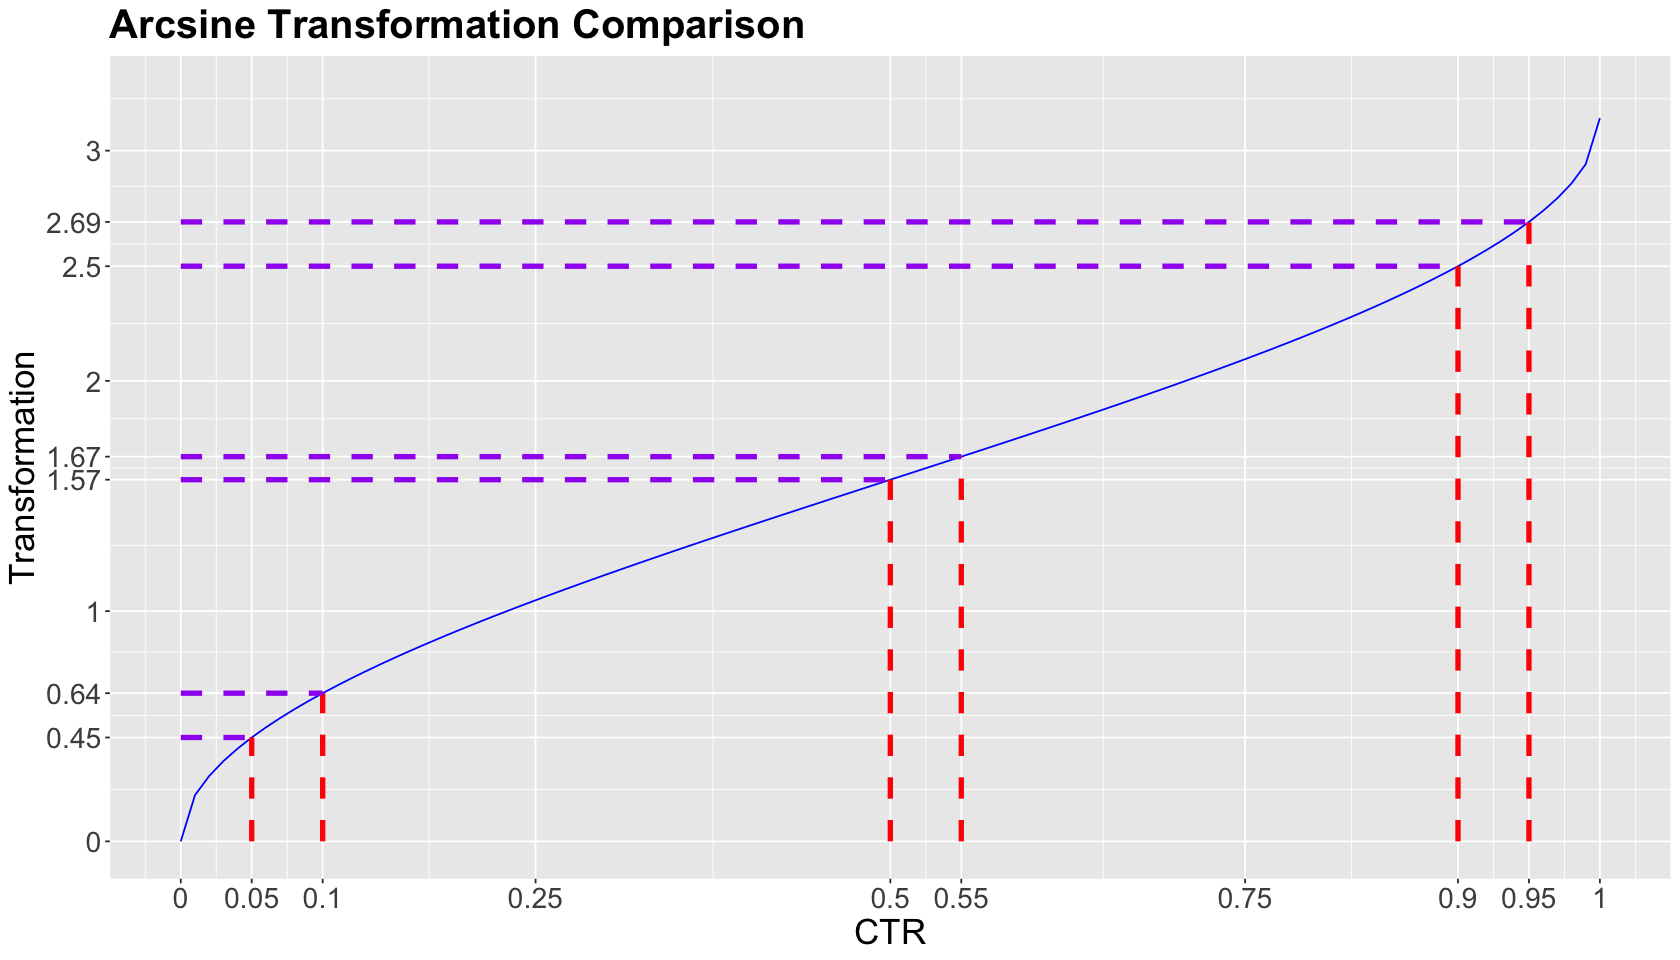

In [15]:
effect_size_plot

```{admonition} Why is this effect behaviour happening in the above plot?
:class: hint
This is heavily related to the **statistic's standard error** of the corresponding **two-proportion hypothesis $Z$-test**. **For our previous practical example**, we want to assess whether an experimental tweak in the website would increase from $\text{CTR}_A = 0.005$ to $\text{CTR}_B = 0.007$, i.e.,

$$\delta_{\text{CTR}} = \text{CTR}_B - \text{CTR}_A = 0.002;$$

with the following hypotheses

$$H_0: \delta_{\text{CTR}} < 0.002$$
$$H_a: \delta_{\text{CTR}} \geq 0.002.$$

Note this **two-proportion $Z$-test** has the following **test statistic**:

$$Z = \frac{\hat{\delta}_{\text{CTR}} - 0.002}{\sqrt{\frac{\hat{\text{CTR}}_A (1 - \hat{\text{CTR}}_A)}{n/2} + \frac{\hat{\text{CTR}}_B (1 - \hat{\text{CTR}}_B)}{n/2}}} = \frac{\hat{\delta}_{\text{CTR}} - 0.002}{\text{SE}\left(\hat{\delta}_{\text{CTR}}
\right)}.$$

Now, this standard error $\text{SE}\left(\hat{\delta_{\text{CTR}}}\right)$ **will behave differently** depending on where we locate our baseline $\text{CTR}_A$ on the $[0, 1]$ range, **even with the same $\delta_{\text{CTR}}$!**
```

Let us plot the behaviour of $\text{SE}\left(\hat{\delta}_{\text{CTR}}\right)$ under different scenarios with a **baseline** 

$$\text{CTR}_A = 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95$$ 

and an overall sample size 

$$n = 50, 100, 200, 500, 1000.$$

The below code will create the corresponding combination grid.

```{attention}
In each scenario, we consider a 

$$\delta_{\text{CTR}} = \text{CTR}_B - \text{CTR}_A = 0.05.$$
```

In [16]:
CTR_A <- c(0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95)
overall_n <- c(50, 100, 200, 500, 1000)
SE_grid <- expand.grid(CTR_A, overall_n)
colnames(SE_grid) <- c("CTR_A", "overall_n")
SE_grid <- SE_grid %>%
  mutate(CTR_B = CTR_A + 0.05, SE = sqrt(((CTR_A * (1 - CTR_A)) / (overall_n / 2)) + ((CTR_B * (1 - CTR_B)) / (overall_n / 2))))

SE_grid

CTR_A,overall_n,CTR_B,SE
<dbl>,<dbl>,<dbl>,<dbl>
0.05,50,0.1,0.07416198
0.15,50,0.2,0.10723805
0.25,50,0.3,0.12609520
0.35,50,0.4,0.13674794
0.45,50,0.5,0.14106736
0.55,50,0.6,0.13964240
0.65,50,0.7,0.13228757
0.75,50,0.8,0.11789826
0.85,50,0.9,0.09327379


Let us check how this standard error graphically behaves across different **baseline $\text{CTR}_A$** by overall sample size $n$:

In [17]:
SE_plot <- ggplot(SE_grid, aes(x = CTR_A, y = SE, colour = as.factor(overall_n))) +
  geom_point(size = 4) +
  geom_line(linewidth = 1) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = expression("Baseline"~CTR[A]), y = "Standard Error") +
  labs(colour = "Overall Sample Size n") +
  ggtitle("Standard Error Behaviour in a Two-proportion Hypothesis Z-test") + 
  scale_x_continuous(
    limits = c(0, 1), breaks = seq(0, 1, 0.1),
  ) +
  scale_y_continuous(
    limits = c(0, 0.15), breaks = seq(0, 0.15, 0.03)
  ) +
  scale_color_brewer(palette = "Dark2")

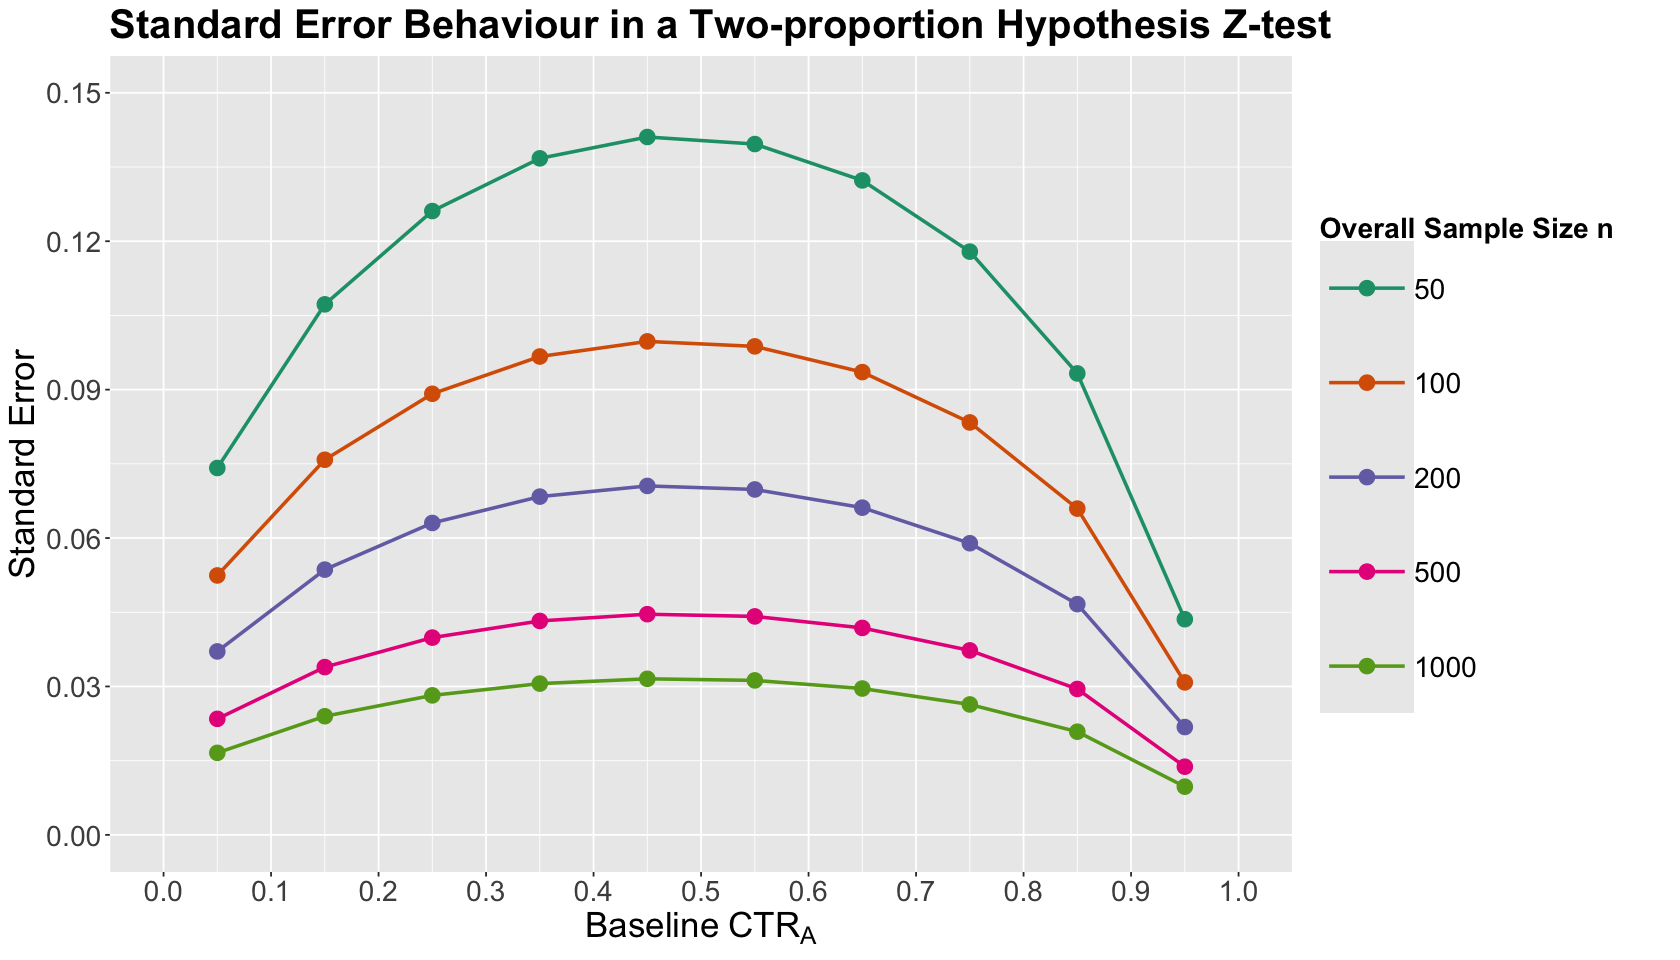

In [18]:
SE_plot

```{admonition} What is the main takeaway from this standard error plot?
:class: hint
We can see that the standard error of the test statistic approaches a maximum point around the middle-end of the range $[0, 1]$ on the $x$-axis. Furthermore, if we increase the overall sample size $n$, we can bend the standard error curve.

Having said all this, we can state the following:

- A **smaller transformed effect size** in CTR Power Analysis would be associated with **larger standard errors and CTRs jointly around $0.5$**; thus, it is in our best interest to increase our overall sample size $n$ so we can overcome a large uncertainty in our estimation.
- A **larger transformed effect size** in CTR Power Analysis would be associated with **smaller standard errors and CTRs jointly closer to the extremes $0$ or $1$**; thus, our required overall sample size $n$ would be smaller given this small uncertainty in our estimation.
```

### 2.2. Using Function `pwr.2p.test()`

As in any sample size computation, we need to set up the **significance level** $\alpha$ and **power** $1 - \beta$:

In [19]:
alpha <- 0.05
pow <- 0.8

Function `pwr.2p.test()` is part of the library `pwr`. It needs the following arguments:

- `h`: Desired **effect size** using the arcsine transformation `CTR_effect_size`.
- `sig.level`: Chosen $\alpha$.
- `power`: Chosen power $1 - \beta$.
- `alternative`: Our hypothesis test is **one-sided**, thus `greater`.

The function will return the required sample size **by treatment** (i.e., the required number of impressions **by treatment**).

In [20]:
CTR_test <- pwr.2p.test(
  h = CTR_effect_size,
  sig.level = alpha,
  power = pow,
  alternative = "greater"
)
CTR_test


     Difference of proportion power calculation for binomial distribution (arcsine transformation) 

              h = 0.02598837
              n = 18307.96
      sig.level = 0.05
          power = 0.8
    alternative = greater

NOTE: same sample sizes


Once we have checked how to use `pwr.2p.test()`, suppose your boss requires a sample size computation analysis with eight different control CTRs for treatment A:

In [21]:
n_lev <- 8
CTR_control_A <- (1:n_lev) / 200
CTR_control_A

[1] 0.005 0.010 0.015 0.020 0.025 0.030 0.035 0.040

Moreover, they also want to evaluate the impact of eight different CTR increases $\delta_{\text{CTR}}$ **when using treatment B**.

In [22]:
CTR_delta <- c((1:n_lev)/400)
CTR_delta

[1] 0.0025 0.0050 0.0075 0.0100 0.0125 0.0150 0.0175 0.0200

Therefore, for a single $\alpha$ and power $1 - \beta$, there will be 64 possible combinations of settings, as shown below in `CTR_experimental_grid`. We use this grid to get the corresponding **OVERALL** A/B testing sample size via `pwr.2p.test()`.

In [23]:
CTR_experimental_grid <- expand.grid(CTR_control_A, CTR_delta)
colnames(CTR_experimental_grid) <- c("CTR_control_A", "CTR_delta")
CTR_experimental_grid$sample_size <- NA

for (i in 1:nrow(CTR_experimental_grid)) {
  CTR_experimental_grid[i, "sample_size"] <- 2 * ceiling(pwr.2p.test(
    h = ES.h(
      CTR_experimental_grid[i, "CTR_control_A"] +
        CTR_experimental_grid[i, "CTR_delta"],
      CTR_experimental_grid[i, "CTR_control_A"]
    ),
    sig.level = alpha,
    power = pow,
    alternative = "greater"
  )$n)
}

In [24]:
CTR_experimental_grid

CTR_control_A,CTR_delta,sample_size
<dbl>,<dbl>,<dbl>
0.005,0.0025,24330
0.010,0.0025,43880
0.015,0.0025,63162
0.020,0.0025,82226
0.025,0.0025,101086
0.030,0.0025,119742
0.035,0.0025,138196
0.040,0.0025,156452
0.005,0.0050,7154


Now, we might wonder: **how do we communicate this whole analysis?** 

We have huge sample sizes above $100,000$ and others below $5,000$. The answer will be in a **clever plotting arrangement**!

The plot below shows the eight values of $\delta_{\text{CTR}} = \text{CTR}_B - \text{CTR}_A$ on the $x$-axis. Moreover, the $y$-axis for sample size $n$ has a primary logarithmic scale on the base 10 on the left-hand side, and the original scale for $n$ on the right-hand side. 

```{attention}
This plotting arrangement on the $y$-axis allows us to compare sample sizes with **DIFFERENT ORDERS OF MAGNITUDE**.
```

Finally, the legend on a colour scale incorporates the different control CTRs for treatment A by $\delta_{\text{CTR}}$ value.

In [25]:
colour_scale <- scales::seq_gradient_pal("blue", "red", "Lab")(seq(0, 1, length.out = n_lev))
breaks_y_axis <- c(
  1000, 5000, 10000, 15000, 20000,
  30000, 50000, 70000, 100000, 150000, 200000
)

CTR_sample_size_plot <- CTR_experimental_grid %>%
  ggplot(aes(x = CTR_delta, y = sample_size, colour = as.factor(CTR_control_A))) +
  geom_hline(yintercept = breaks_y_axis, linetype = "dotted") +
  geom_point(size = 5.5) +
  scale_y_continuous(
    trans = "log10", breaks = breaks_y_axis, labels = round(log10(breaks_y_axis), 2),
    sec.axis = sec_axis(~.,
      name = "Required Overall n", breaks = breaks_y_axis,
      labels = scales::comma(breaks_y_axis)
    )
  ) +
  xlab(expression("Experimental CTR Increase"~delta["CTR"])) +
  ylab("Required Overall n (Base 10 Log-Scale)") +
  scale_colour_manual(values = colour_scale, guide = guide_legend(reverse = TRUE)) +
  labs(colour = "CTR Control A") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 15),
    axis.title = element_text(size = 21),
    legend.position = "right",
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 3, unit = "cm")),
    legend.key.size = unit(1, 'cm'),
    legend.box.margin = margin(100, 100, 100, 100)
  ) +
  ggtitle(expression("A/B Testing Overall Required Impressions with"~alpha~"= 0.05"~"and Power = 0.8")) +
  scale_x_continuous(breaks = CTR_delta) 

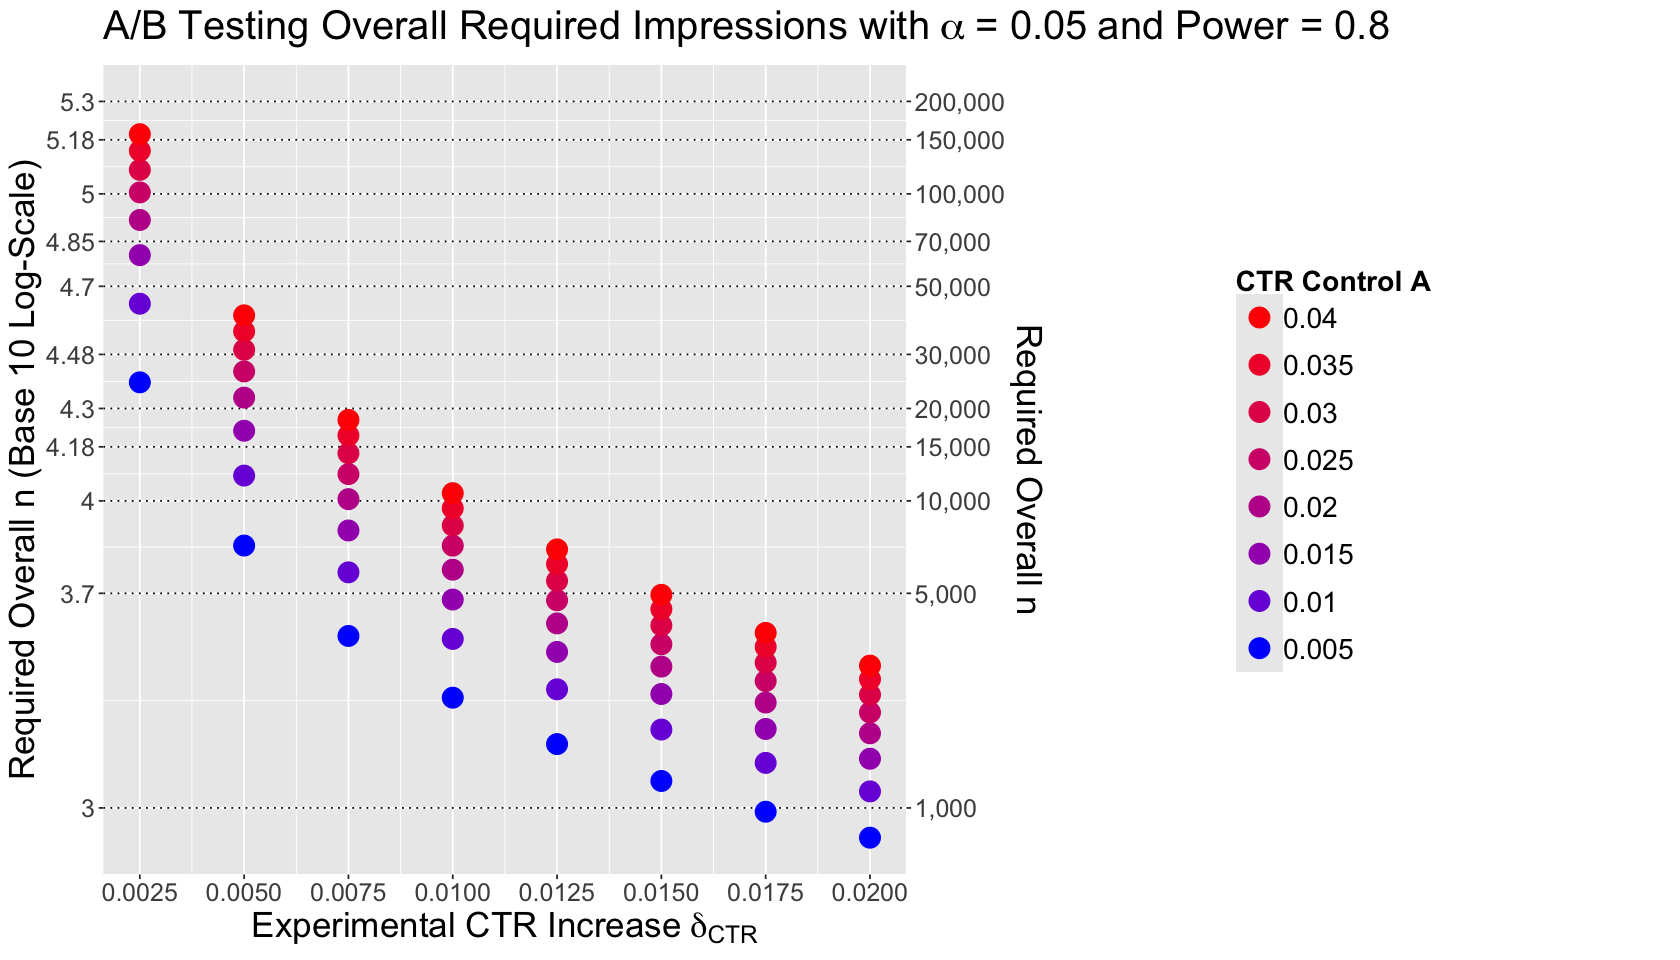

In [26]:
CTR_sample_size_plot

```{admonition} What is the main takeaway from this sample size plot?
:class: hint
We are seeing the arcsine transformation in action here for the effect size via the baseline $\text{CTR}_A$. It is susceptible to this baseline $\text{CTR}_A$ but also to small increases $\delta_{\text{CTR}}$.
```

**So, where are we standing with these CTR results?**

Firstly, we might be running the experiment for a long time. Therefore, **can we stop the A/B testing earlier once we see a significant result?** Let us explore **early stopping**.

## 3. Early Stopping in A/B Testing

We will begin with a sample size computation to elaborate on early stopping in A/B testing. Suppose our current site (i.e., **control treatment A**) has a $\text{CTR}_A$ of 3%. Our team has developed a tweak website layout (i.e., **experimental treatment B**).

**We are very optimistic that the tweak to the site could get us to 4.5% CTR, making a solid business case.** Hence, before conducting the corresponding A/B testing, we will power it accordingly via `pwr.2p.test()`.

In [27]:
control_ctr <- 0.03
tweak_ctr <- 0.045
alpha <- 0.05
pow <- 0.8

n_AB <- 2 * ceiling(
  pwr.2p.test(
    h = ES.h(tweak_ctr, control_ctr),
    sig.level = alpha,
    power = pow,
    alternative = "greater"
  )$n
)
n_AB # Overall sample size

[1] 3930

### 3.1. Introduction to Peeking

We obtain an **OVERALL** sample size of $n = 3930$. That is a lot of visitors! 

```{important}
**If we are running this experiment online while randomizing the experimental units in real-time**, we presumably have access to the data as it is being collected. So we can check the state of our data collection as much as we want throughout the whole A/B testing. **This is called PEEKING.**
```

Moreover, if you can peek at the data as much as you want in real-time, you might be tempted to **EARLY STOP** the A/B testing. Hence, **if we keep performing the corresponding hypothesis testing every time we peek at the process**, can we stop the experiment earlier before collecting the total sample size $n = 3930$?

```{attention}
Peeking in A/B testing still involves computing your overall sample size, call it $n_{\text{max}}$, before starting the experiment. **If at some peek your UPDATED test statistic hits significance before we accrue all $n_{\text{max}}$ experimental units, then A/B testing randomization and data collection will stop.**
```

By appealing to the previous logic, as soon as we are convinced that the experimental version of the site is more profitable than the control, we **early stop** the A/B testing and serve the experimental version to all visitors.

Again, simulation will be our friend to **illustrate** and **practice** the concept of **peeking**. Function `sim_monitor_track()` simulates an A/B testing for comparing CTRs with two website versions as follows:

- The function **sequentially** generates **independent** visitors/impressions (i.e., **experimental units**), one by one, and **randomly** allocates them to either treatment A (control) or B (experimental tweak). 
- Moreover, it generates the **experimental unit's response** (click or non-click) based on the population CTRs: $\text{CTR}_A$ and $\text{CTR}_B$. 
- Once each experimental unit has been recruited and their data has been collected, we **compute/update** the corresponding $z$-statistic and evaluate whether we reach significance or not (i.e., we conclude that $\text{CTR}_B > \text{CTR}_A$ at a significance level $\alpha$).
- If we reach significance, the A/B testing will **stop before reaching the projected overall sample size $n_{\text{max}}$**.

This function needs three arguments: `n_max` (projected maximum overall sample size $n_{\text{max}}$), `CTR_A` (population $\text{CTR}_A$), and `CTR_B` (population $\text{CTR}_B$).

In [28]:
sim_monitor_track <- function(n_max, CTR_A, CTR_B) {
  # Significance level in A/B testing
  alpha <- 0.05

  # Data to record in each iteration to compute the z-statistic
  data <- matrix(0, 2, 2)
  z <- 0 # No test statistic at the beginning of the A/B testing
  n <- 0 # No visitors at the beginning of the A/B testing

  # Recordings of z statistics throughout the A/B testing
  z_opt <- rep(NA, n_max)

  # We will recruit A/B testing visitors within the loop
  # The experiment will last while we do not have a significant result
  # AND we do not reach the maximum number of experimental units (n_max)
  while ((z <= qnorm(1 - alpha)) && (n < n_max)) {
    n <- n + 1 # Increasing the number of recruited visitors

    # Randomize the visitor to treatment A (0) or B (1)
    x <- sample(0:1, size = 1)
    # See if they click on the link (1) or not (0)
    y <- rbinom(1, size = 1, prob = (1 - x) * CTR_A + x * CTR_B)

    # Update data table and recompute z-statistic
    data[x + 1, y + 1] <- data[x + 1, y + 1] + 1

    # Computing z-statistic
    if (min(data) > 0) {
      z <- (log(data[1, 1]) + log(data[2, 2]) - log(data[1, 2]) - log(data[2, 1])) /
        sqrt(sum(1 / data))
    }
    z_opt[n] <- z # Recording new z-statistic
  }
  return(list(z = z_opt, n = n))
}

We will execute this function `4` times (i.e., we will simulate four A/B testings). Their outputs will be the computed **$z$-statistic sequences** throughout each experiment. We will use `n_max = 3930`, `CTR_A = 0.03`, and `CTR_B = 0.045`.

In [29]:
set.seed(554)

n_sim <- 4

z_sim <- matrix(NA, n_AB, n_sim)

for(m in 1:n_sim){
  z_sim[, m] <- sim_monitor_track(n_max = 3930, CTR_A = 0.03, CTR_B = 0.045)$z
}

Then, we wrangle our simulation results in the data frame `tracking_results`.

In [30]:
tracking_results <- data.frame(
  n = rep(1:n_AB, times = n_sim),
  sim = rep(1:n_sim,
    each = n_AB
  ),
  z = c(z_sim)
)

The plot below illustrates the sequence of $z$-statistics we computed every time we peek at the A/B testing once we got a new visitor, randomized them, and recorded their response. The simulation sequences are coloured by each of the four replicates (**a replicate is equivalent to one execution of `sim_monitor_track()`**).

Note there is a horizontal dashed line indicating the cutoff $z_{1 - \alpha} = 1.64$ with $\alpha = 0.05$. Recall that we are continuously performing one-sided tests. Hence, when the computed test statistic $z_{\text{test}} > z_{1 - \alpha}$, **we have SUPPOSEDLY collected ENOUGH evidence to infer that $\text{CTR}_B > \text{CTR}_A$ with a significance level $\alpha$**.

In [31]:
options(warn = -1)

tracking_plot <- tracking_results %>% ggplot(aes(x = n, y = z, colour = as.factor(sim))) +
  geom_line() +
  geom_hline(yintercept = qnorm(1-alpha), linetype = "dashed") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  xlab("Progressive Number of Vistors in A/B Testing") +
  ylab("z-statistic") +
  labs(colour = "Simulation Replicate") +
  ggtitle("z-statistic Tracking by Simulation Replicate") +
  scale_color_brewer(palette = "Dark2")

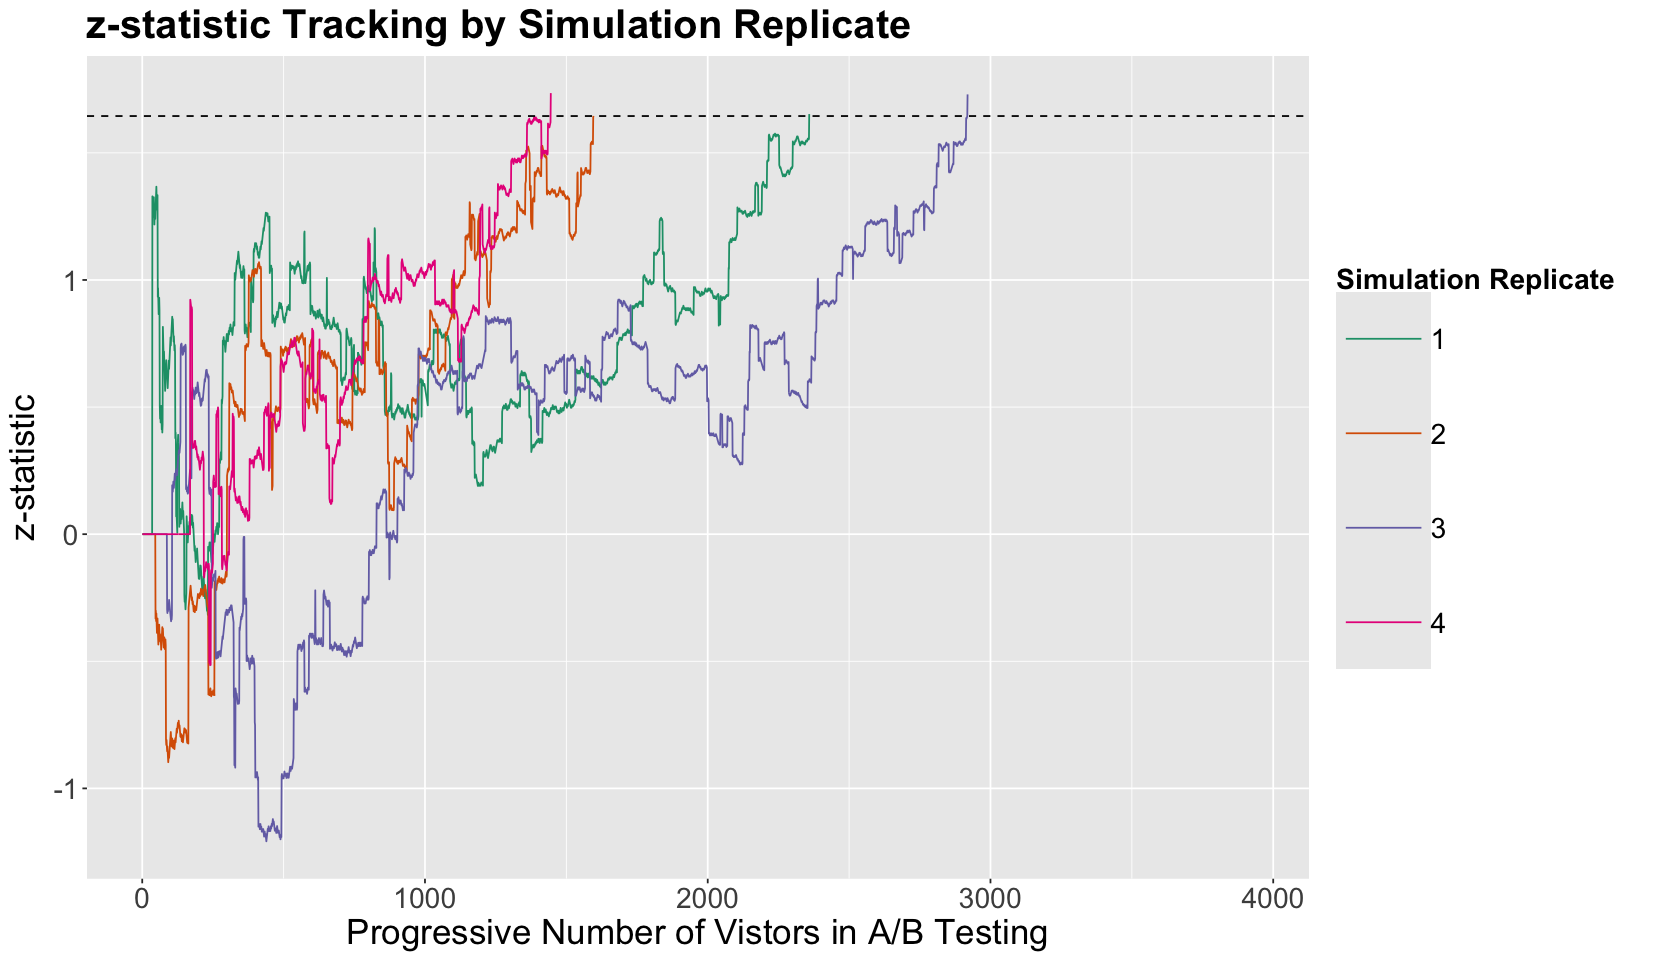

In [32]:
tracking_plot

```{admonition} What is the main takeaway from this $z$-statistic tracking plot?
:class: hint
**Under this population scenario**, the four simulation replicates lead us to gather evidence to conclude that 

$$\text{CTR}_B > \text{CTR}_A,$$

given that eventually our computed $z_{\text{test}} > z_{1 - \alpha}$ (i.e., the $z$-statistic sequences cross the cutoff horizontal dashed line). 

Note it **MIGHT** be beneficial to end the A/B testing before reaching the maximum planned overall sample size $n_{max}$ **WHILE PEEKING**. However, let us dig more into this matter!
```

### 3.2. Three Simulation Studies with Aggressive Peeking

**Before putting the previous appealing peeking idea into practice**, we would need to run three simulation studies to check some key metrics (just as we did in {doc}`lecture3_randomization_and_blocking` and {doc}`lecture4_more_blocking_and_power`). These studies involve what we call **aggresive peeking** (i.e., when we check our data and test statistic every time we have a new experimental unit).

Thus, let us run three whole simulation studies. The function `sim_monitor()` does the same job as `sim_monitor_track()`, both require the same arguments. However, `sim_monitor()` will only return the **final $z_{\text{test}}$** for a given A/B testing simulation replicate and the number of visitors at which we reach **significance** that will be **less or equal than `n_max`**.

In [33]:
sim_monitor <- function(n_max, CTR_A, CTR_B) {
  # Significance level in A/B testing
  alpha <- 0.05

  # Data to record in each iteration to compute the z-statistic
  data <- matrix(0, 2, 2)
  z <- 0 # No test statistic at the beginning of the A/B testing
  n <- 0 # No visitors at the beginning of the A/B testing

  # We will recruit A/B testing visitors within the loop
  # The experiment will last while we do not have a significant result
  # AND we do not reach the maximum number of experimental units (n_max)
  while ((z <= qnorm(1 - alpha)) && (n < n_max)) {
    n <- n + 1 # Increasing the number of recruited visitors

    # Randomize the visitor to treatment A (0) or B (1)
    x <- sample(0:1, size = 1)
    # See if they click on the link (1) or not (0)
    y <- rbinom(1, size = 1, prob = (1 - x) * CTR_A + x * CTR_B)

    # Update data table and recompute z-statistic
    data[x + 1, y + 1] <- data[x + 1, y + 1] + 1

    # Recomputing z-statistic
    if (min(data) > 0) {
      z <- (log(data[1, 1]) + log(data[2, 2]) - log(data[1, 2]) - log(data[2, 1])) /
        sqrt(sum(1 / data))
    }
  }
  return(list(z = z, n = n))
}

#### 3.2.1. What happens when $\text{CTR}_B > \text{CTR}_A$ in a simulation study if we apply aggressive peeking everytime there is a new visitor?

We will use the arguments `n_max = 3930`, `CTR_A = 0.03`, and `CTR_B = 0.045` in `sim_monitor()` with `1000` replicates for our simulation study.

In [34]:
set.seed(554)

m_rep <- 1000 # Number of replicates

results_1 <- list(n = rep(NA, m_rep), z = rep(NA, m_rep)) # List of results

for (i in 1:m_rep) {
  sim <- sim_monitor(n_max = 3930, CTR_A = 0.03, CTR_B = 0.045)
  results_1$z[i] <- sim$z
  results_1$n[i] <- sim$n
}

Under this scenario, we sort the `1000` values corresponding to those effective sample sizes at which the A/B testing was stopped **from the smallest to the largest**. Then, we make seven bins. In each bin, we obtain the proportion of $z$-statistics that were less or equal than the cutoff $z_{1 - \alpha} = 1.64$ with $\alpha = 0.05$ (column `(-Inf,1.64]`) and that proportion larger than $z_{1 - \alpha}$ (column `(1.64, Inf]`).

In [35]:
sim_study_results_1 <- table(
  cut(results_1$n, breaks = c(0, 500, 1000, 1500, 2000, 2500, 3000, 3930), dig.lab = 4),
  cut(results_1$z, breaks = c(-Inf, qnorm(1 - alpha), Inf))
) / m_rep

sim_study_results_1 <- format(sim_study_results_1)

In [36]:
sim_study_results_1

,"(-Inf,1.64]","(1.64, Inf]"
"(0,500]",0.000,0.338
"(500,1000]",0.000,0.207
"(1000,1500]",0.000,0.119
"(1500,2000]",0.000,0.091
"(2000,2500]",0.000,0.067
"(2500,3000]",0.000,0.038
"(3000,3930]",0.087,0.053


```{admonition} What is the main takeaway from this simulation study in the context of this population?
:class: hint
The expression $\text{CTR}_B > \text{CTR}_A$ corresponds to our alternative hypothesis $H_a$. We know this hypothesis is in fact true since the population $\text{CTR}_A = 0.03$ and $\text{CTR}_B = 0.045$. When $z_{\text{test}} \leq z_{1 - \alpha}$, we fail reject the null hypothesis $H_0$ which is committing type II error! Hence this table is telling us that the **observed power in this simulation study** is $1 - \beta = 1 - 0.087 = 0.913$!

It seems that an **aggresive peeking** improves the power of the test when, in fact, $\text{CTR}_B > \text{CTR}_A$. However, note that the increase from $\text{CTR}_A$ to $\text{CTR}_B$ is 50%.

**What would happen if the percentage CTR increase is smaller?**
```

#### 3.2.2. What happens when $\text{CTR}_B > \text{CTR}_A$  under a smaller percentage increase in a simulation study if we apply aggresive peeking every time there is a new visitor?

We will use the arguments `n_max = 3930`, `CTR_A = 0.03`, and `CTR_B = 0.036` in `sim_monitor()` with `1000` replicates for our simulation study. **This is a CTR percentage increase of 20%.**

In [37]:
set.seed(554)

m_rep <- 1000 # Number of replicates

results_2 <- list(n = rep(NA, m_rep), z = rep(NA, m_rep)) # List of results

for (i in 1:m_rep) {
  sim <- sim_monitor(n_max = 3930, CTR_A = 0.03, CTR_B = 0.036)
  results_2$z[i] <- sim$z
  results_2$n[i] <- sim$n
}

Then, we obtain the seven-bin table as in the previous simulation study.

In [38]:
sim_study_results_2 <- table(
  cut(results_2$n, breaks = c(0, 500, 1000, 1500, 2000, 2500, 3000, 3930), dig.lab = 4),
  cut(results_2$z, breaks = c(-Inf, qnorm(1 - alpha), Inf))
) / m_rep

sim_study_results_2 <- format(sim_study_results_2)

In [39]:
sim_study_results_2

,"(-Inf,1.64]","(1.64, Inf]"
"(0,500]",0.000,0.182
"(500,1000]",0.000,0.100
"(1000,1500]",0.000,0.078
"(1500,2000]",0.000,0.050
"(2000,2500]",0.000,0.040
"(2500,3000]",0.000,0.045
"(3000,3930]",0.454,0.051


```{admonition} What is the main takeaway from this simulation study in the context of this population?
:class: hint
When there is an **aggresive peeking** in a population scenario under a small percentage CTR increase, then we see a **concerning power decrease**. The power is $1 - \beta = 1 - 0.454 = 0.546$.
```

#### 3.2.3. What happens when $\text{CTR}_B = \text{CTR}_A$ in a simulation study if we apply aggresive peeking everytime there is a new visitor?

We will use the arguments `n_max = 3930`, `CTR_A = 0.03`, and `CTR_B = 0.03` in `sim_monitor()` with `1000` replicates for our simulation study.

In [40]:
set.seed(554)

m_rep <- 1000 # Number of replicates

results_3 <- list(n = rep(NA, m_rep), z = rep(NA, m_rep)) # List of results

for (i in 1:m_rep) {
  sim <- sim_monitor(n_max = 3930, CTR_A = 0.03, CTR_B = 0.03)
  results_3$z[i] <- sim$z
  results_3$n[i] <- sim$n
}

Then, we obtain the seven-bin table as in the previous simulation study.

In [41]:
sim_study_results_3 <- table(
  cut(results_3$n, breaks = c(0, 500, 1000, 1500, 2000, 2500, 3000, 3930), dig.lab = 4),
  cut(results_3$z, breaks = c(-Inf, qnorm(1 - alpha), Inf))
) / m_rep

sim_study_results_3 <- format(sim_study_results_3)

In [42]:
sim_study_results_3

,"(-Inf,1.64]","(1.64, Inf]"
"(0,500]",0.000,0.103
"(500,1000]",0.000,0.051
"(1000,1500]",0.000,0.029
"(1500,2000]",0.000,0.019
"(2000,2500]",0.000,0.013
"(2500,3000]",0.000,0.015
"(3000,3930]",0.751,0.019


```{admonition} What is the main takeaway from this simulation study in the context of this population?
:class: hint
In this context, the null hypothesis $H_0$ is true! Hence the proportion of replicates where $z_{\text{test}} > z_{1 - \alpha}$ correspond to the type I error. In this case, an **aggresive peeking** severely inflates the type I error $\alpha = 1 - 0.751 = 0.249$.
```

### 3.3. Final Simulation Studies with Principled Peeking

Recall that **non-peeking** and **aggresive peeking** are the following extremes in A/B testing:

- Accruing all $n_{\text{max}}$ experimental units and not computing/looking at the test statistic until then (**non-peeking**).
- **Real-time** monitoring of the test statistic and stopping early (**aggresive peeking**).

Both extremes might not be good ideas! Hence, is there something in between these two extremes?

```{admonition} Basics of Principled Peeking
:class: important
A common A/B testing practice is **principled peeking**. This practice involves defining a fixed number of peeks **before starting the experiment**. It has the following characteristics:

- Define an $m$ number of **principled peeks** **before starting the experiment**.
- **Principled peeks** will begin at a certain collected number of recruited experimental units $n_{\text{min}} > 0$.
- **Principled peeks** will be evenly spaced between experimental units $n_{\text{min}}$ and $n_{\text{max}}$.
- Use the Bonferroni correction to adjust $\alpha$ in our hypothesis testings such that $\alpha / m$.
- If at a certain **principled peek** we reach significance before $n_{\text{max}}$, then the A/B testing stops. 
- If we never reach significance before $n_{\text{max}}$, then the last **principled peek** will correspond to $n_{\text{max}}$.
```

Function `sim_rej()` executes a set of simulation CTR studies under a defined number of principled peeks (one study with `m_rep` replicates per principled peek). These peeks begin at the experimental unit `n_min`. The rest of the arguments are the same ones from our previous functions.

In [43]:
sim_rej <- function(n_min, n_max, alpha = 0.05, CTR_A, CTR_B, n_peeks, m_rep) {

  # Setting up overall study metrics by number of peek setting
  rej_mean <- rep(0, length(n_peeks))
  rej_sd <- rep(0, length(n_peeks))
  n_mean <- rep(0, length(n_peeks))
  n_sd <- rep(0, length(n_peeks))

  # Beginning studies
  # By number of principled peekings
  for (n in 1:length(n_peeks)) {
    
    z_cutoff <- qnorm(1 - alpha / n_peeks[n]) # Note the Bonferroni correction for z cutoff value!
    
    # Visitor numbers at which peek happens
    n_inspect <- round(n_min + (n_max - n_min) * (1:n_peeks[n]) / n_peeks[n])

    # Individual simulation study metrics
    rej <- rep(0, m_rep)
    n_stop <- rep(0, m_rep)

    # Beginning individual simulation
    for (m in 1:m_rep) {

      # Test statistics to record
      zz <- rep(0, length(n_inspect))

      # Simulating the sequence of all visitors
      x <- sample(0:1, size = n_max, replace = TRUE)
      y <- rbinom(n_max, size = 1, prob = (1 - x) * CTR_A + x * CTR_B)

      # Executing planned hypothesis testings (by number of peeks)
      for (ni in 1:length(n_inspect)) {

        # Updating terms to compute test statistic
        np <- n_inspect[ni]
        x_new <- sum(x[1:np])
        x_old <- np - x_new
        y_1_new <- sum(x[1:np] * y[1:np])
        y_1_old <- sum((1 - x[1:np]) * y[1:np])

        p_star <- (y_1_new + y_1_old) / np
        z <- (y_1_new / x_new - y_1_old / x_old) / (sqrt(p_star * (1 - p_star) * (1 / x_new + 1 / x_old)))
        if (is.nan(z)) {
          z <- 0
        }
        zz[ni] <- z
      }

      # Shall we stop the study at a given peek?
      rej[m] <- any(zz > z_cutoff) # +1 in metric if we reject the null hypothesis
      if (rej[m]) {
        n_stop[m] <- n_inspect[which(zz > z_cutoff)[1]]
      } else {
        n_stop[m] <- n_max
      }
    }

    # Computing overall study metrics by number of peeks settings
    rej_mean[n] <- mean(rej) # Proportion of times we rejected the null hypothesis
    rej_sd[n] <- sd(rej)
    n_mean[n] <- mean(n_stop) # Average number of visitors required for early stopping
    n_sd[n] <- sd(n_stop)
    
  }
  return(list(rej_mean = rej_mean, rej_sd = rej_sd, n_mean = n_mean, n_sd = n_sd))
}

We execute `sim_rej()` with the arguments below. Note we set up the following principled peeks: `1, 2, 5, 10, 15, 20, 25`. Our `n_min` parameter is `1000`. Moreover, we run these studies under two realities:

- **Reality 1:** No change in CTRs between both treatments.
- **Reality 2:** Increase from $\text{CTR}_A = 0.03$ to $\text{CTR}_B = 0.045$.

In [44]:
set.seed(321)

# Running reality 1
reality_1 <- sim_rej(
  n_min = 1000, n_max = 3930, CTR_A = 0.03, CTR_B = 0.03,
  n_peeks = c(1, 2, 5, 10, 15, 20, 25), m_rep = 1000
)

# Collecting type I error for Reality 1
reality_1_type_1_error <- tibble(n_peeks = c(1, 2, 5, 10, 15, 20, 25), type_1 = reality_1$rej_mean)

# Running reality 2
reality_2 <- sim_rej(
  n_min = 1000, n_max = 3930, CTR_A = 0.03, CTR_B = 0.045,
  n_peeks = c(1, 2, 5, 10, 15, 20, 25), m_rep = 1000
)

# Collecting power for Reality 2
reality_2_power <- tibble(n_peeks = c(1, 2, 5, 10, 15, 20, 25), power = reality_2$rej_mean)

# Collecting average recruited visitors by reality and number of peeks
avg_recruited <- tibble(
  Reality = as.factor(c(rep("Reality 1", 7), rep("Reality 2", 7))),
  n_peeks = rep(c(1, 2, 5, 10, 15, 20, 25), 2),
  avg_number = c(reality_1$n_mean, reality_2$n_mean)
)

Now, let us check the below plotting arrangement. The plot on top illustrates the average sampled experimental units by principled peeking strategy on the $x$-axis by reality. The other two plots at the bottom show the type I error rate in **Reality 1** and the power in **Reality 2** by principled peeking strategy on the $x$-axis.

In [45]:
options(repr.plot.height = 12, repr.plot.width = 14)

avg_vistors_reality <- ggplot(avg_recruited, aes(x = n_peeks, y = avg_number, colour = Reality)) +
  geom_point(size = 4) +
  geom_line(size = 1) +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Number of Peeks in A/B Testing", y = "Average Recruited Visitors") +
  scale_x_continuous(breaks = c(1, 2, 5, 10, 15, 20, 25), labels = c(1, 2, 5, 10, 15, 20, 25)) +
  ggtitle("Average Recruited Visitors by Reality") +
  scale_color_manual(values=c("red", "blue")) +
  coord_cartesian(ylim = c(2900, 4000)) +
  scale_y_continuous(breaks = seq(3000, 4000, 200))

type_1_error_reality_1 <- ggplot(reality_1_type_1_error, aes(x = n_peeks, y = type_1)) +
  geom_point(size = 4, colour = "red") +
  geom_line(size = 1, colour = "red") +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Number of Peeks in A/B Testing", y = "Type I Error Rate") +
  coord_cartesian(ylim = c(0, 0.06)) +
  scale_y_continuous(breaks = seq(0, 0.06, 0.01)) +
  scale_x_continuous(breaks = c(1, 2, 5, 10, 15, 20, 25), labels = c(1, 2, 5, 10, 15, 20, 25)) +
  ggtitle("Reality 1: Type I Error Rate by Number of Peeks")

power_reality_2 <- ggplot(reality_2_power, aes(x = n_peeks, y = power)) +
  geom_point(size = 4, colour = "blue") +
  geom_line(size = 1, colour = "blue") +
  theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    strip.text = element_text(size = 21),
    legend.title = element_text(size = 17, face = "bold", margin = margin(r = 1, unit = "cm")), 
    legend.text = element_text(size = 17, margin = margin(r = 1, unit = "cm")),
    legend.key.size = unit(2, "cm")
  ) +
  labs(x = "Number of Peeks in A/B Testing", y = "Power") +
  coord_cartesian(ylim = c(0.4, 0.9)) +
  scale_y_continuous(breaks = seq(0.4, 0.9, 0.05)) +
  scale_x_continuous(breaks = c(1, 2, 5, 10, 15, 20, 25), labels = c(1, 2, 5, 10, 15, 20, 25)) +
  ggtitle("Reality 2: Power by Number of Peeks")

bottom_row <- plot_grid(type_1_error_reality_1, power_reality_2, align = 'h')

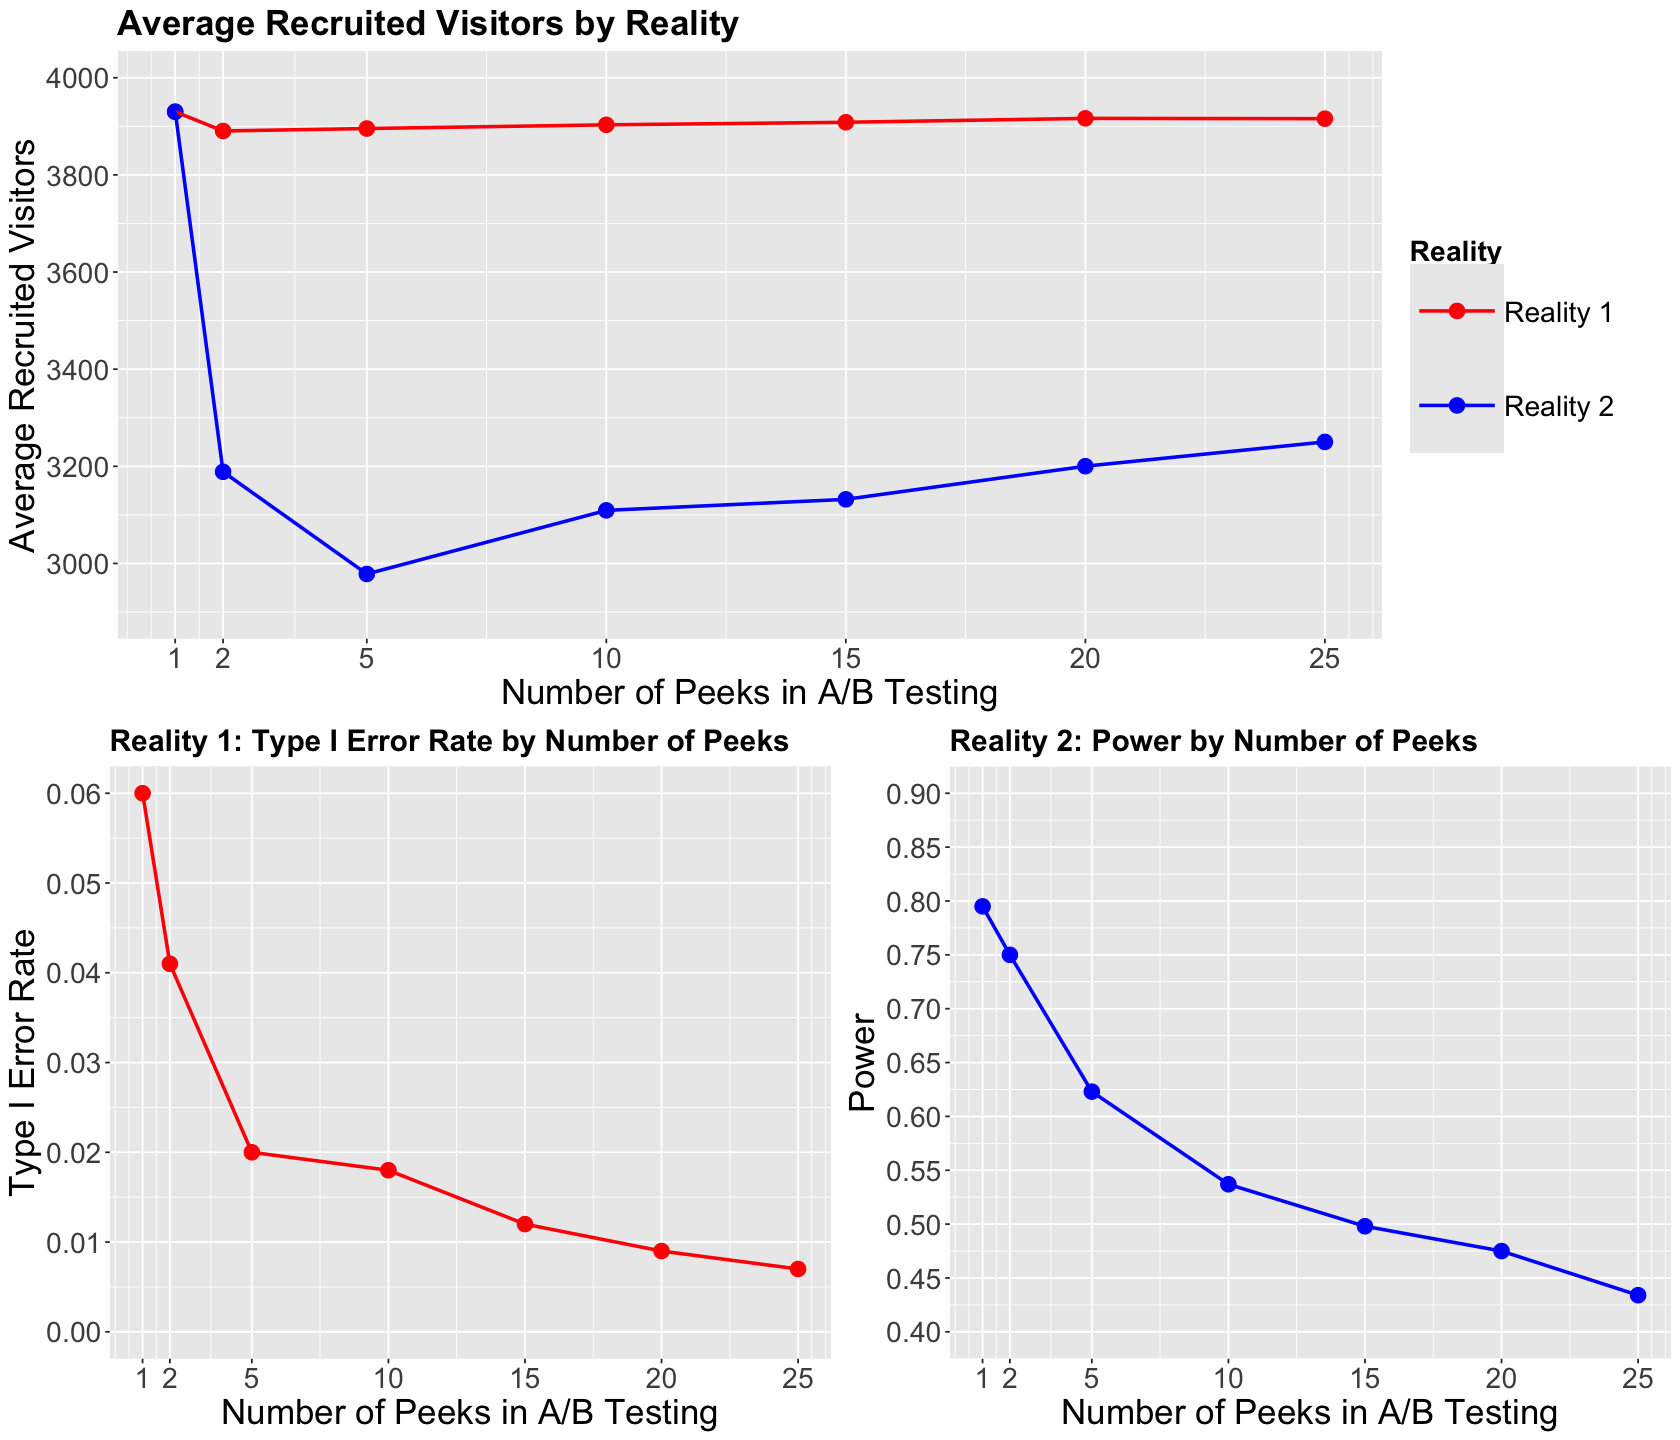

In [46]:
plot_grid(avg_vistors_reality, bottom_row, nrow = 2)

```{admonition} What are the main takeaways from these plots?
:class: hint
- There is a decrease in recruited visitors when we have 5 principled peeks in **Reality 2** ($\text{CTR}_B > \text{CTR}_A $). This does not happen in **Reality 1** ($\text{CTR}_B = \text{CTR}_A $) at any number of principled peeks.
- The Bonferroni correction greatly prevents false positives as we increase the number of principled peeks in **Reality 1**.
- We need to be cautious when increasing the number of principled peeks in **Reality 2** since this might impact the power. From these plots, **2 principled peeks are ideal**!
```

## 4. Wrapping Up

- A clever plotting in Power Analysis is mandatory in A/B testing practice.
- Early stopping in A/B testing is an appealing idea, but we have to be statistically cautious.
- In **aggressive peeking**, we see "decent" power if indeed the experimental treatment B beats the control treatment A **by a large amount**. However, if both CTRs are close, then **aggressive peeking** plays against our power.
- In **aggressive peeking**, we will have type I error rate inflation if experimental treatment B is actually no better than control treatment A.
- **Principled peeking** involves planning our test checking and relies on the Bonferroni correction. It prevents type I error rate inflation if experimental treatment B is actually no better than control treatment A.